In [112]:
import pandas as pd
import networkx as nx
import numpy as np

In [113]:
def read_excel_to_dataframe(file_path):
    # Read all sheets of the Excel file
    dfs = pd.read_excel(file_path, sheet_name=None)
    # Return the dictionary of dataframes
    return dfs


# Use the function
dfs = read_excel_to_dataframe('Discovery Tour - Shadowing Days - Shadowers & Hosts - 2 .xlsx')

# Assign each dataframe to a separate variable
df1 = dfs['Shadowers']
df2 = dfs['Hosts']
df3 = dfs['areas']

print(df1.ID.count())
print(df2.ID.count())

271
106


In [114]:
#cleaning the data
df1.columns = df1.columns.str.replace('\xa0', '')
df2.columns = df2.columns.str.replace('\xa0', '')

# Create separate dataframes for rows where the command of English is not comfortable enough
df1_not_comfortable = df1.loc[df1['How is your command of English?'] == 'I am not comfortable enough in English to shadow someone.']
df2_not_comfortable = df2.loc[df2['How is your command of English?'] == 'I am not comfortable enough in English to be a host for international colleagues.\xa0']

# Remove these rows from the original dataframes
df1 = df1.loc[df1['How is your command of English?'] != 'I am not comfortable enough in English to shadow someone.']
df2 = df2.loc[df2['How is your command of English?'] != 'I am not comfortable enough in English to be a host for international colleagues.\xa0']

# Define the columns to join
columns_to_join = [
    'Payroll', 'HR Software', 'Consultancy', 'Communications', 'Marketing',
    'Sales & Business Development', 'Mergers & Acquisitions', 'IT & Products',
    'Finance', 'Legal, compliance, risk & audit', 'Corporate Data & Business Intelligence',
    'Programme Management', 'People', 'Management Assistants', 'Facilities', 'CustomerExperience'
]

df1 = df1.copy()
df1.loc[:, 'AreasOfInterest'] = df1[columns_to_join].apply(
    lambda row: ' '.join([str(val) for val in row.values if pd.notna(val)]), axis=1)

# Define the base columns to drop
base_columns_to_drop = [
    'How is your command of English?', 'Payroll', 'HR Software', 'Consultancy', 'Communications',
    'Marketing', 'Sales & Business Development', 'Mergers & Acquisitions', 'IT & Products',
    'Finance', 'Legal, compliance, risk & audit', 'Corporate Data & Business Intelligence',
    'Programme Management', 'People', 'Management Assistants', 'Facilities', 'CustomerExperience'
]

# Define the unique columns to drop for df1
unique_columns_to_drop_df1 = ['In which language(s) would you be comfortable to shadow someone?']

# Define the unique columns to drop for df2
unique_columns_to_drop_df2 = ['Which languages do you master sufficient to be a host?']

# Combine the base and unique columns to drop for each dataframe
columns_to_drop_df1 = base_columns_to_drop + unique_columns_to_drop_df1
columns_to_drop_df2 = base_columns_to_drop + unique_columns_to_drop_df2

# Drop the specified columns
df1 = df1.drop(columns=columns_to_drop_df1)
df2 = df2.drop(columns=columns_to_drop_df2)

In [115]:
# Create new dataframes for rows where 'AreasOfInterest' is an empty string or 'nan'
df1_no_interest = df1[(df1['AreasOfInterest'] == '') | (df1['AreasOfInterest'].isna())]
df2_no_interest = df2[(df2['AreasOfInterest'] == '') | (df2['AreasOfInterest'].isna())]

# Drop rows with NaN values in 'AreasOfInterest' column
df1 = df1.dropna(subset=['AreasOfInterest'])
df2 = df2.dropna(subset=['AreasOfInterest'])

In [116]:
# Create separate dataframes for rows where 'Matched' is not null
df1_matched = df1.loc[df1['Matched'].notnull()]
df2_matched = df2.loc[df2['Matched'].notnull()]

# Filter out these rows from the original dataframes
df1 = df1.loc[df1['Matched'].isnull()]
df2 = df2.loc[df2['Matched'].isnull()]

# Create a new empty bipartite graph
B = nx.Graph()

# Add nodes with the bipartite attribute for shadowers
B.add_nodes_from(('df1_' + df1.index.astype(str)), bipartite=0)

# Add nodes with the bipartite attribute for hosts
# Each host is represented by multiple nodes based on the number of shadowers they can host
for i, row in df2.iterrows():
    for _ in range(int(row['How many shadowers would you like to host?'])):
        B.add_node('df2_' + str(i) + '_' + str(_), bipartite=1)

# Add edges between shadowers and hosts if they have at least one common area of interest
for i, row_i in df1.iterrows():
    for j, row_j in df2.iterrows():
        areas_i = [area.strip() for area in row_i['AreasOfInterest'].split(';') if area.strip() != '']
        areas_j = [area.strip() for area in row_j['AreasOfInterest'].split(';') if area.strip() != '']
        common_areas = set(areas_i) & set(areas_j)
        if common_areas:  # if there is at least one common area of interest
            for _ in range(int(row_j['How many shadowers would you like to host?'])):
                #print(f"Adding edge between df1_{i} and df2_{j}_{_} for common areas: {common_areas}")
                B.add_edge('df1_' + str(i), 'df2_' + str(j) + '_' + str(_), weight=1)  # weight is set to 1

# Identify the isolated nodes
isolated_nodes = list(nx.isolates(B))

# Remove 'df1_' from the isolated nodes and convert them to integers
isolated_nodes_indices = [int(node.replace('df1_', '')) for node in isolated_nodes]

# Create a new DataFrame that contains only the isolated nodes
isolated_nodes_df = df1.loc[isolated_nodes_indices]

# Remove the isolated nodes from the graph
B.remove_nodes_from(isolated_nodes)

# Run the matching algorithm if the graph is connected
if nx.is_connected(B):
    # Ensure that the top_nodes set only includes nodes that are present in the graph B
    top_nodes = {'df1_' + str(i) for i in df1.index if 'df1_' + str(i) in B.nodes}
    matching = nx.algorithms.bipartite.matching.hopcroft_karp_matching(B, top_nodes=top_nodes)
    matches = pd.DataFrame(matching.items(), columns=['Shadower', 'Host'])
    matches = matches[matches['Shadower'].str.startswith('df1_')]
    matches.reset_index(drop=True, inplace=True)
    print(matches)
else:
    print("The graph is still disconnected after removing isolated nodes. Cannot find maximum matching.")

    Shadower       Host
0     df1_75    df2_6_0
1    df1_182    df2_1_0
2    df1_145   df2_10_0
3     df1_16   df2_19_0
4    df1_228   df2_14_0
..       ...        ...
121    df1_6  df2_102_1
122  df1_198  df2_100_0
123    df1_3  df2_103_0
124   df1_86  df2_103_1
125   df1_32  df2_104_0

[126 rows x 2 columns]


In [117]:
matches

,Shadower,Host
0,df1_75,df2_6_0
1,df1_182,df2_1_0
2,df1_145,df2_10_0
3,df1_16,df2_19_0
4,df1_228,df2_14_0
...,...,...
121,df1_6,df2_102_1
122,df1_198,df2_100_0
123,df1_3,df2_103_0
124,df1_86,df2_103_1


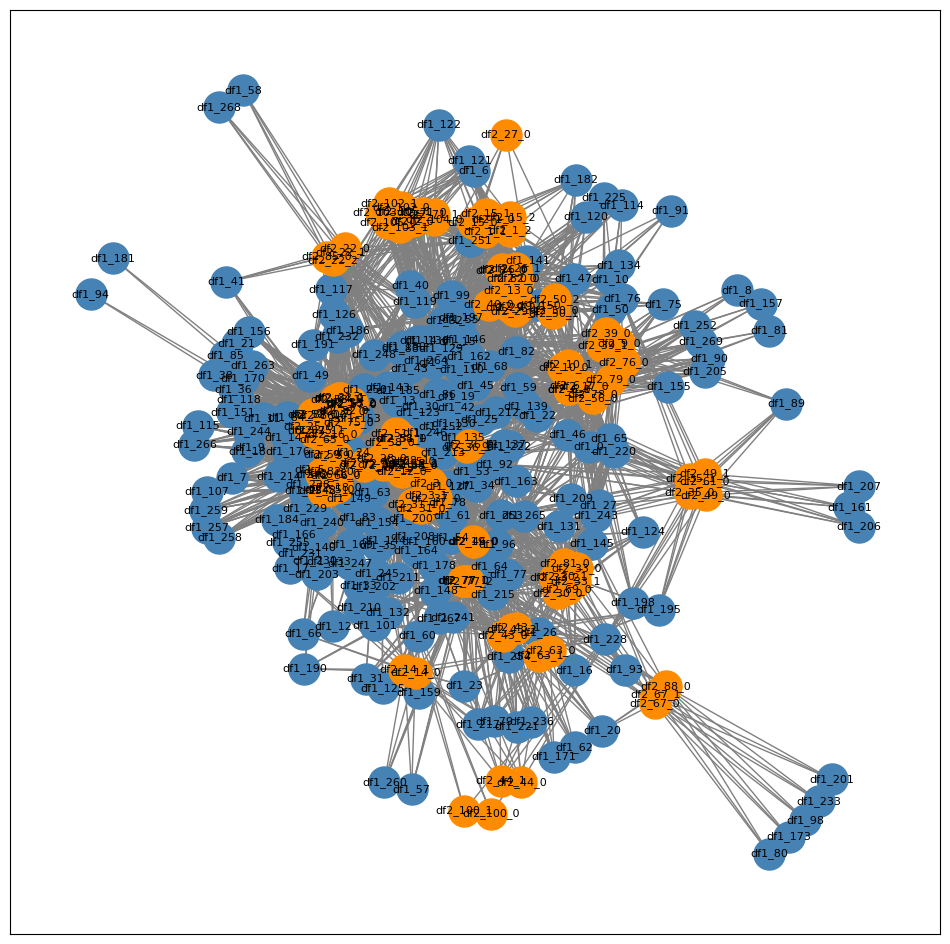

In [118]:
import matplotlib.pyplot as plt

# Set the figure size
plt.figure(figsize=(12, 12))

# Create a layout for the nodes
layout = nx.spring_layout(B, seed=42)

# Separate nodes by group
shadowers = [node for node in B.nodes() if node.startswith('df1_')]
hosts = [node for node in B.nodes() if node.startswith('df2_')]

# Draw the nodes specifying the node color
nx.draw_networkx_nodes(B, layout, nodelist=shadowers, node_color='steelblue', node_size=500)
nx.draw_networkx_nodes(B, layout, nodelist=hosts, node_color='darkorange', node_size=500)

# Draw the edges
nx.draw_networkx_edges(B, layout, edge_color='gray')

# Draw the node labels
nx.draw_networkx_labels(B, layout, font_size=8)

# Display the graph
plt.show()

In [119]:
# Remove 'df1_' from 'Shadower' column
matches['Shadower'] = matches['Shadower'].str.replace('df1_', '')

# Remove 'df2_' and the last '_x' from 'Host' column
matches['Host'] = matches['Host'].str.replace('df2_', '')
matches['Host'] = matches['Host'].str.replace('_\d+$', '', regex=True)

In [120]:
# Convert 'Shadower' and 'Host' columns to integer type
matches['Shadower'] = matches['Shadower'].astype(int)
matches['Host'] = matches['Host'].astype(int)

# Merge matches DataFrame with df1 on 'Shadower' column
merged_df = pd.merge(matches, df1, left_on='Shadower', right_index=True)

# Merge the resulting DataFrame with df2 on 'Host' column
merged_df = pd.merge(merged_df, df2, left_on='Host', right_index=True, suffixes=('_shadower', '_host'))

In [121]:
merged_df

,Shadower,Host,ID_shadower,Matched_shadower,Country_shadower,AreasOfInterest_shadower,ID_host,Matched_host,Country_host,How many shadowers would you like to host?,AreasOfInterest_host
0,75,6,79,NaN,Belgium,Content Marketing;Brand Marketing;Digital Mark...,7,NaN,Belgium,3,Brand Marketing;Market Research;Content Market...
1,182,1,186,NaN,Spain,Learning;Talent Management;Compensation & Bene...,2,NaN,Belgium,3,Talent Management;
2,145,10,149,NaN,Belgium,Digital Marketing; Product Owner; Controller; ...,11,NaN,Belgium,2,Content Marketing;Digital Marketing;Marketing ...
3,16,19,20,NaN,Mauritius,IT Support;Software Development;Functional/Bus...,20,NaN,France,1,HR Software Implementation;Product Owner;IT Su...
4,228,14,232,NaN,Finland,IT Asset Management;Quality Assurance (QA) Eng...,15,NaN,Belgium,2,Architecture;
...,...,...,...,...,...,...,...,...,...,...,...
121,6,102,10,NaN,Croatia,HR Business Partner;HR Operations;Talent Acqui...,104,NaN,Netherlands,2,Talent Acquisition;
122,198,100,202,NaN,Belgium,Social Media; Facilities;,102,NaN,Croatia,2,Facilities;
123,3,103,7,NaN,Sweden,Payroll Mid-Market;Payroll SME; HR Software Im...,105,NaN,Germany,2,Talent Acquisition;
124,86,103,90,NaN,United Kingdom,Payroll Mid-Market; Sales Enablement; Software...,105,NaN,Germany,2,Talent Acquisition;


In [122]:
# Split 'AreasOfInterest' columns by ';' to get lists of interests
merged_df['AreasOfInterest_shadower'] = merged_df['AreasOfInterest_shadower'].str.split(';')
merged_df['AreasOfInterest_host'] = merged_df['AreasOfInterest_host'].str.split(';')

# Strip whitespace from each interest and filter out any empty strings
merged_df['AreasOfInterest_shadower'] = merged_df['AreasOfInterest_shadower'].apply(lambda x: [i.strip() for i in x if i.strip() != ''])
merged_df['AreasOfInterest_host'] = merged_df['AreasOfInterest_host'].apply(lambda x: [i.strip() for i in x if i.strip() != ''])

# Find the intersection of these lists to get the common interests
merged_df['Common_AreaOfInterest'] = merged_df.apply(lambda row: list(set(row['AreasOfInterest_shadower']) & set(row['AreasOfInterest_host'])), axis=1)

# Join the common interests with ';' and store them in 'Common_AreaOfInterest'
merged_df['Common_AreaOfInterest'] = merged_df['Common_AreaOfInterest'].apply(lambda x: ';'.join(x))

In [123]:
# Drop the original 'AreasOfInterest' columns
merged_df = merged_df.drop(columns=['AreasOfInterest_shadower', 'AreasOfInterest_host', 'Matched_host', 'Matched_shadower'])

In [124]:
merged_df

,Shadower,Host,ID_shadower,Country_shadower,ID_host,Country_host,How many shadowers would you like to host?,Common_AreaOfInterest
0,75,6,79,Belgium,7,Belgium,3,Content Marketing;Brand Marketing
1,182,1,186,Spain,2,Belgium,3,Talent Management
2,145,10,149,Belgium,11,Belgium,2,Digital Marketing
3,16,19,20,Mauritius,20,France,1,IT Support;Software Development;Functional/Bus...
4,228,14,232,Finland,15,Belgium,2,Architecture
...,...,...,...,...,...,...,...,...
121,6,102,10,Croatia,104,Netherlands,2,Talent Acquisition
122,198,100,202,Belgium,102,Croatia,2,Facilities
123,3,103,7,Sweden,105,Germany,2,Talent Acquisition
124,86,103,90,United Kingdom,105,Germany,2,Talent Acquisition
